# MNIST with ConvNets

> <span style="color:gray">
Original [Theano/Lasagne tutorial](https://github.com/DeepLearningDTU/nvidia_deep_learning_summercamp_2016/blob/master/lab1/lab1_FFN.ipynb) by 
Lars Maaløe ([larsmaaloee](https://github.com/larsmaaloee)),
Søren Kaae Sønderby ([skaae](https://github.com/skaae)), and 
Casper Sønderby ([casperkaae](https://github.com/casperkaae)). 
Converted to TensorFlow by 
Alexander R. Johansen ([alrojo](https://github.com/alrojo)), 
and updated by 
Toke Faurby ([faur](https://github.com/Faur)).
</span>


In this lab we will solve the MNIST problem again, but this time with convolutional networks.
You will get a to try stacking of convolutional layers, max pooling and strided convolutions which are all important techniques in current convolutional layers network architectures.


### Dependancies and supporting functions


Loading dependancies and supporting functions by running the code block below.

In [34]:
from __future__ import absolute_import, division, print_function 

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
# import sklearn.datasets
import tensorflow as tf
import os
import sys
sys.path.append(os.path.join('.', '..')) 
import utils 


## The MNIST data set

We load the MNIST dataset.
This time the data is keept as images (`shape = [28, 28, 1]`), and not flattended into vectors (`shape = [784]`).
This allows the convolutional network to take advantage of the structure of the data

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz

Information on dataset
    ----------------------
Training size:	 55000
Test size	 10000
Validation size	 5000

Data summaries
Image shape		 (28, 28, 1)
Image type		 <class 'numpy.ndarray'>
Image min/max value	 0.0 / 1.0
Label shape		 (10,)
Label type		 <class 'numpy.float64'>


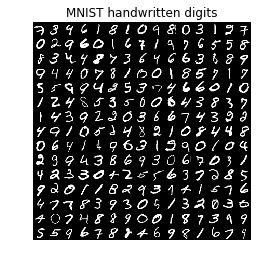

In [35]:
# Load data (download if you haven't already)
from tensorflow.examples.tutorials.mnist import input_data
mnist_data = input_data.read_data_sets('MNIST_data', 
                                       one_hot=True,   # Convert the labels into one hot encoding
                                       dtype='float32', # rescale images to `[0, 1]`
                                       reshape=False, # Don't flatten the images to vectors
                                      )

## Print dataset statistics and visualize
print('')
utils.mnist_summary(mnist_data)



## Building the model

We will use Keras layers, which are documented [here](https://keras.io/layers/about-keras-layers/)

In [36]:
import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D
from tensorflow.contrib.layers import flatten # We use this flatten, as it works better than 
                                              # the Keras 'Flatten' for some reason


In [37]:
tf.reset_default_graph()

num_classes = 10
height, width, nchannels = 28, 28, 1
padding = 'same'

x_pl = tf.placeholder(tf.float32, [None, height, width, nchannels], name='xPlaceholder')
y_pl = tf.placeholder(tf.float64, [None, num_classes], name='yPlaceholder')
y_pl = tf.cast(y_pl, tf.float32)

filters_1 = 9
filters_2 = 9

kernel_size_1 = (4,4)
kernel_size_2 = (3,3)

pool_size_1 = (5,5)
pool_size_2 = (5,5)
pool_size_3 = (5,5)
               
print('Trace of the tensors shape as it is propagated through the network.')
print('Layer name \t Output size')
print('----------------------------')

with tf.variable_scope('convLayer1'):
    conv1 = Conv2D(filters_1, kernel_size_1, strides=(1,1), activation='relu')
    conv2 = Conv2D(filters_2, kernel_size_2, strides=(1,1), padding=padding, activation='relu')
    conv3 = Conv2D(filters_3, kernel_size_3, strides=(1,1), padding=padding, activation='relu')
    
    pool1 = MaxPooling2D(pool_size=pool_size_1, strides=None, padding=padding)
    pool2 = MaxPooling2D(pool_size=pool_size_2, strides=None, padding=padding)
    pool3 = MaxPooling2D(pool_size=pool_size_3, strides=None, padding=padding)
    
    print('x_pl \t\t', x_pl.get_shape())
    x = conv1(x_pl)
    print('conv1 \t\t', x.get_shape())
    x = pool1(x)
    print('pool1 \t\t', x.get_shape())
    x = conv2(x)
    print('conv2 \t\t', x.get_shape())
    x = pool2(x)
    print('pool2 \t\t', x.get_shape())
    x = flatten(x)
    print('Flatten \t', x.get_shape())

with tf.variable_scope('output_layer'):
    denseOut = Dense(units=num_classes, activation='softmax')
    
    y = denseOut(x)
    print('denseOut\t', y.get_shape())    

print('Model consits of ', utils.num_params(), 'trainable parameters.')

Trace of the tensors shape as it is propagated through the network.
Layer name 	 Output size
----------------------------
x_pl 		 (?, 28, 28, 1)
conv1 		 (?, 25, 25, 9)
pool1 		 (?, 5, 5, 9)
conv2 		 (?, 5, 5, 9)
pool2 		 (?, 1, 1, 9)
Flatten 	 (?, 9)
denseOut	 (?, 10)
Model consits of  991 trainable parameters.


In [38]:
## Launch TensorBoard, and visualize the TF graph
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.45)

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:
    tmp_def = utils.rename_nodes(sess.graph_def, lambda s:"/".join(s.split('_',1)))
    utils.show_graph(tmp_def)

In [39]:
with tf.variable_scope('loss'):
    # computing cross entropy per sample
    cross_entropy = -tf.reduce_sum(y_pl * tf.log(y+1e-8), reduction_indices=[1])

    # averaging over samples
    cross_entropy = tf.reduce_mean(cross_entropy)

    
with tf.variable_scope('training'):
    # defining our optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001)

    # applying the gradients
    train_op = optimizer.minimize(cross_entropy)

    
with tf.variable_scope('performance'):
    # making a one-hot encoded vector of correct (1) and incorrect (0) predictions
    correct_prediction = tf.equal(tf.argmax(y, axis=1), tf.argmax(y_pl, axis=1))

    # averaging the one-hot encoded vector
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [40]:
#Test the forward pass
x_batch, y_batch = mnist_data.train.next_batch(4)

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:
# with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    y_pred = sess.run(fetches=y, feed_dict={x_pl: x_batch})

assert y_pred.shape == y_batch.shape, "ERROR the output shape is not as expected!" \
        + " Output shape should be " + str(y.shape) + ' but was ' + str(y_pred.shape)

print('Forward pass successful!')

Forward pass successful!


In [41]:
mnist_data.train._epochs_completed = 0

#Training Loop
batch_size = 100
max_epochs = 10


valid_loss, valid_accuracy = [], []
train_loss, train_accuracy = [], []
test_loss, test_accuracy = [], []


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print('Begin training loop')

    try:
        while mnist_data.train.epochs_completed < max_epochs:
            _train_loss, _train_accuracy = [], []
            
            ## Run train op
            x_batch, y_batch = mnist_data.train.next_batch(batch_size)
            fetches_train = [train_op, cross_entropy, accuracy]
            feed_dict_train = {x_pl: x_batch, y_pl: y_batch}
            _, _loss, _acc = sess.run(fetches_train, feed_dict_train)
            
            _train_loss.append(_loss)
            _train_accuracy.append(_acc)
            

            ## Compute validation loss and accuracy
            if mnist_data.train.epochs_completed % 1 == 0 \
                    and mnist_data.train._index_in_epoch <= batch_size:
                train_loss.append(np.mean(_train_loss))
                train_accuracy.append(np.mean(_train_accuracy))

                fetches_valid = [cross_entropy, accuracy]
                
                feed_dict_valid = {x_pl: mnist_data.validation.images, y_pl: mnist_data.validation.labels}
                _loss, _acc = sess.run(fetches_valid, feed_dict_valid)
                
                valid_loss.append(_loss)
                valid_accuracy.append(_acc)
                print("Epoch {} : Train Loss {:6.3f}, Train acc {:6.3f},  Valid loss {:6.3f},  Valid acc {:6.3f}".format(
                    mnist_data.train.epochs_completed, train_loss[-1], train_accuracy[-1], valid_loss[-1], valid_accuracy[-1]))
        
        
        test_epoch = mnist_data.test.epochs_completed
        while mnist_data.test.epochs_completed == test_epoch:
            x_batch, y_batch = mnist_data.test.next_batch(batch_size)
            feed_dict_test = {x_pl: x_batch, y_pl: y_batch}
            _loss, _acc = sess.run(fetches_valid, feed_dict_test)
            test_loss.append(_loss)
            test_accuracy.append(_acc)
        print('Test Loss {:6.3f}, Test acc {:6.3f}'.format(
                    np.mean(test_loss), np.mean(test_accuracy)))


    except KeyboardInterrupt:
        pass



Begin training loop
Epoch 1 : Train Loss  0.577, Train acc  0.820,  Valid loss  0.569,  Valid acc  0.841
Epoch 2 : Train Loss  0.279, Train acc  0.890,  Valid loss  0.370,  Valid acc  0.892
Epoch 3 : Train Loss  0.197, Train acc  0.980,  Valid loss  0.307,  Valid acc  0.908
Epoch 4 : Train Loss  0.282, Train acc  0.900,  Valid loss  0.289,  Valid acc  0.914
Epoch 5 : Train Loss  0.164, Train acc  0.930,  Valid loss  0.242,  Valid acc  0.927
Epoch 6 : Train Loss  0.328, Train acc  0.910,  Valid loss  0.227,  Valid acc  0.932
Epoch 7 : Train Loss  0.276, Train acc  0.910,  Valid loss  0.211,  Valid acc  0.936
Epoch 8 : Train Loss  0.057, Train acc  1.000,  Valid loss  0.193,  Valid acc  0.945
Epoch 9 : Train Loss  0.269, Train acc  0.910,  Valid loss  0.198,  Valid acc  0.940
Epoch 10 : Train Loss  0.197, Train acc  0.940,  Valid loss  0.178,  Valid acc  0.944
Test Loss  0.182, Test acc  0.947


## Training

(<matplotlib.text.Text at 0x7f6a74611a58>,
 (0.75, 1.03))

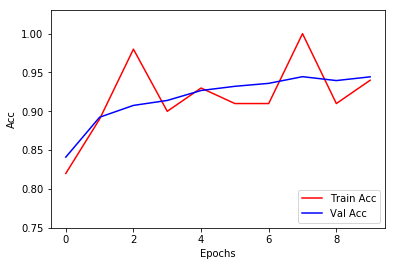

In [42]:
epoch = np.arange(len(train_loss))
plt.figure()
plt.plot(epoch, train_accuracy,'r', epoch, valid_accuracy,'b')
plt.legend(['Train Acc','Val Acc'], loc=4)
plt.xlabel('Epochs'), plt.ylabel('Acc'), plt.ylim([0.75,1.03])

# Assignments

#### <span style="color:red"> EXE 1.1 </span> Manual calculations

![](images/conv_exe.png)



1. Manually convolve the input, and compute the convolved features. No padding and no strieds.
1. Perform `2x2` max pooling on the convolved features. Stride of 2.

___

<span style="color:blue"> Answer: </span>

1) Solution.

Being the output of the convolution the 2D spatial signal:


$$O = \begin{bmatrix}
    o_{1}       & o_{2} \\
    o_{3}       & o_{4} \\
\end{bmatrix} $$

$$o_1 = 0*0+0*0+0*2
    +0*0+0*1+1*2
    +0*0+0*2+2*3 = 2 + 6 = 8 $$

$$o_2 = 0*0+0*0+1*2
    +0*0+1*1+2*2
    +0*0+2*2+3*3 = 2 + 1 +4 +4+9 = 20$$

$$o_3 = 0*0+0*0+1*2
    +0*0+0*1+2*2
    +0*0+1*2+2*3 = 2+4+2+6 = 14$$

$$o_4 = 0*0+1*0+2*2
    +0*0+2*1+3*2
    +1*0+2*2+3*3 = 4 + 2 + 6 + 4 +9 = 25$$

$$O = \begin{bmatrix}
    8       & 20 \\
    14      & 25 \\
\end{bmatrix} $$

2) Solution

Well, this should be easy since we only have a 2x2 input signal so the output of the Max pool is 25.



#### <span style="color:red"> EXE 1.2 </span> Reducing the resolution
One of the important features of convolutional networks are their ability to reduce the spatial resolution, while retaining the important features.
Effectively this gives a local translational invariance and reduces the computation. 
This is most often done with **maxpooling** or by using strides.

1. Using only convolutional layers and pooling operations reduce the feature map size to `1x1xF`.
    * The number of feature maps, `F`, is up to you.

___

<span style="color:blue"> Write down what you did: </span>

``` 
I guess the easiest thing is to just apply the MaxPool operation once to the already convolved and MaxPooled (14x14xF) signal. This would just give the maximum value of the 14x14 signal. Since this is a Deep Learning Course what we will do is first apply another Convolution with the proper padding to keep the dimensions, followed by a Maxpooling of (2x2) followed by another Convolution with the same passing and finally a last Maxpooling of (7x7) to get the the 1x1xF signal. Where F is the number of filters of the last convolution. Other approaches, could be to not add padding to the convolution and therefore you keep losing dimesions. On the other hand that may take more free parameters to train.
```





In [79]:
tf.reset_default_graph()

num_classes = 10
height, width, nchannels = 28, 28, 1
padding = 'same'

x_pl = tf.placeholder(tf.float32, [None, height, width, nchannels], name='xPlaceholder')
y_pl = tf.placeholder(tf.float64, [None, num_classes], name='yPlaceholder')
y_pl = tf.cast(y_pl, tf.float32)

filters_1 = 16
filters_2 = 5
filters_3 = 10

kernel_size_1 = (4,4)
kernel_size_2 = (3,3)
kernel_size_3 = (2,2)

pool_size_1 = (2,2)
pool_size_2 = (2,2)
pool_size_3 = (7,7)
with tf.variable_scope('convLayer1'):
    conv1 = Conv2D(filters_1, kernel_size_1, strides=(1,1), padding=padding, activation='relu')
    conv2 = Conv2D(filters_2, kernel_size_2, strides=(1,1), padding=padding, activation='relu')
    conv3 = Conv2D(filters_3, kernel_size_3, strides=(1,1), padding=padding, activation='relu')
    
    pool1 = MaxPooling2D(pool_size=pool_size_1, strides=None, padding=padding)
    pool2 = MaxPooling2D(pool_size=pool_size_2, strides=None, padding=padding)
    pool3 = MaxPooling2D(pool_size=pool_size_3, strides=None, padding=padding)
    
    print('x_pl \t\t', x_pl.get_shape())
    x = conv1(x_pl)
    print('conv1 \t\t', x.get_shape())
    x = pool1(x)
    print('pool1 \t\t', x.get_shape())
    x = conv2(x)
    print('conv2 \t\t', x.get_shape())
    x = pool2(x)
    print('pool2 \t\t', x.get_shape())
    x = conv3(x)
    print('conv2 \t\t', x.get_shape())
    x = pool3(x)
    print('pool3 \t\t', x.get_shape())
    x = flatten(x)
    print('Flatten \t', x.get_shape())

with tf.variable_scope('output_layer'):
    denseOut = Dense(units=num_classes, activation='softmax')
    
    y = denseOut(x)
    print('denseOut\t', y.get_shape())    

print('Model consits of ', utils.num_params(), 'trainable parameters.')

x_pl 		 (?, 28, 28, 1)
conv1 		 (?, 28, 28, 16)
pool1 		 (?, 14, 14, 16)
conv2 		 (?, 14, 14, 5)
pool2 		 (?, 7, 7, 5)
conv2 		 (?, 7, 7, 10)
pool3 		 (?, 1, 1, 10)
Flatten 	 (?, 10)
denseOut	 (?, 10)
Model consits of  1317 trainable parameters.


``` 
Paste the trace of the tensors shape as it is propagated through the network here:

x_pl 		 (?, 28, 28, 1)
conv1 		 (?, 28, 28, 16)
pool1 		 (?, 14, 14, 16)
conv2 		 (?, 14, 14, 5)
pool2 		 (?, 7, 7, 5)
conv2 		 (?, 7, 7, 10)
pool3 		 (?, 1, 1, 10)
Flatten 	 (?, 10)
denseOut	 (?, 10)
Model consits of  1317 trainable parameters.
```

#### <span style="color:red"> EXE 1.3 </span> Play around with the network.
The MNIST dataset is so easy to solve with convolutional networks that it isn't interesting to spend to much time on maximizing performance.
A more interesting question is *how few parameters can you solve it with?*

1. Try and minimize the number of parameters, while keeping validation accuracy about 95%. Try changing the

    * Number of layers
    * Number of filters
    * Kernel size
    * Pooling size
1. Once happy take note of the performance, number of parameters (printed automatically), and describe the network below.
___


<span style="color:blue"> Answer: </span>

We assume that we keep the batch size and number of epochs; and the rest of the parameters the same and we only play with the rest of the parameters described above. We can see that the kernel size has a big effect on the number of parameters since if we use squared filters, then the number of parameters grows quadratically. Also, the number of parameters grows linearly with the number of filters, and the number of convolutional layers. After trying several configurations, the chosen network has the following operations:

- First layer with 9 filters of (4x4), no padding, resulting in a 25x25 signal. Followed by 5x5 maxpooling.
- Then we apply 9 filters of (3x3) again with padding to keep the dimensions and apply another 5x5 maxpooling to obtain the 1x1xF system.

The results is a system with under 1.000 parameters (991) that achieves the desired accuracy. You can see the performance of the system in the initial trained network.


#### <span style="color:red"> EXE 1.4 </span> Comparing dense and convolutional networks

1. Now create a densely connected network (the ones from lab 1), and see how good performance you can get with a similar number of parameters.
___

<span style="color:blue"> Describe your findings: </span>

Below we have the code for the densely connected network with one hidden layer from lab 1. It is pretty hard to obtain a low number of parameters scheme since the number of input dimensions is already 784, so under the constraints that we cannot perform any preprocessing like feature selection, the number of hidden neurons that gives a similar number of degrees of freedom (weights and biases) is very low, 1 or 2. We also constraint the training to the same number of epochs, since even though this architecture is worse in the way for example that it overlooks any spatial relationship of the pixels (not like the convolutional network), a fine tuned training could also achieve good results. Overall, the convolutional network requires much more less parameters thanks to the reduction of dimensions and it does not need to be so fine tuned to achieve good results. On the other hand each epoch takes several times more time. The achieved accuracy for 2 hidden neurons and 10 epochs is just 55%.



Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Information on dataset
----------------------
Training size:	 55000
Test size	 10000
Validation size	 5000

Data summaries
Image shape		 784
Image type		 <class 'numpy.float32'>
Image min/max value	 0.0 / 1.0
Label shape		 10
Label type		 <class 'numpy.float64'>


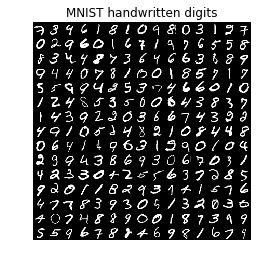

In [25]:
from __future__ import absolute_import, division, print_function 

import os
import sys
sys.path.append(os.path.join('.', '..')) 
import utils
import tensorflow as tf
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import datetime

# Load data (download if you haven't already)
from tensorflow.examples.tutorials.mnist import input_data
mnist_data = input_data.read_data_sets('MNIST_data', 
                                       one_hot=True,   # Convert the labels into one hot encoding
                                       dtype='float32' # rescale images to `[0, 1]`
                                      )
## Print dataset statistics and visualize
print("""Information on dataset
----------------------""")
print("Training size:\t", mnist_data.train.num_examples)
print("Test size\t", mnist_data.test.num_examples)
print("Validation size\t", mnist_data.validation.num_examples)

num_features = mnist_data.train.images[0].shape[0]
num_classes = mnist_data.train.labels[0].shape[0]

print('\nData summaries')
print("Image shape\t\t", num_features)
print("Image type\t\t", type(mnist_data.train.images[0][0]))
print("Image min/max value\t", np.min(mnist_data.train.images), '/', np.max(mnist_data.train.images))
print("Label shape\t\t", num_classes)
print("Label type\t\t", type(mnist_data.train.labels[0][0]))


## Plot a few MNIST examples
img_to_show = 15
idx = 0
canvas = np.zeros((28*img_to_show, img_to_show*28))
for i in range(img_to_show):
    for j in range(img_to_show):
        canvas[i*28:(i+1)*28, j*28:(j+1)*28] = mnist_data.train.images[idx].reshape((28, 28))
        idx += 1
plt.figure(figsize=(4,4))
plt.axis('off')
plt.imshow(canvas, cmap='gray')
plt.title('MNIST handwritten digits')
plt.show()

## EXTRA CODE TO INTIALIZE VARIABLES

num_features = num_features
num_output = num_classes



Model consits of  1600 trainable parameters.
Begin training
Epoch 0, Train Cost: 2.033	Val Cost: 2.030	 Val acc: 0.186
Epoch 2, Train Cost: 1.648	Val Cost: 1.649	 Val acc: 0.410
Epoch 4, Train Cost: 1.498	Val Cost: 1.502	 Val acc: 0.496
Epoch 6, Train Cost: 1.406	Val Cost: 1.410	 Val acc: 0.535
Epoch 8, Train Cost: 1.340	Val Cost: 1.343	 Val acc: 0.551
Done


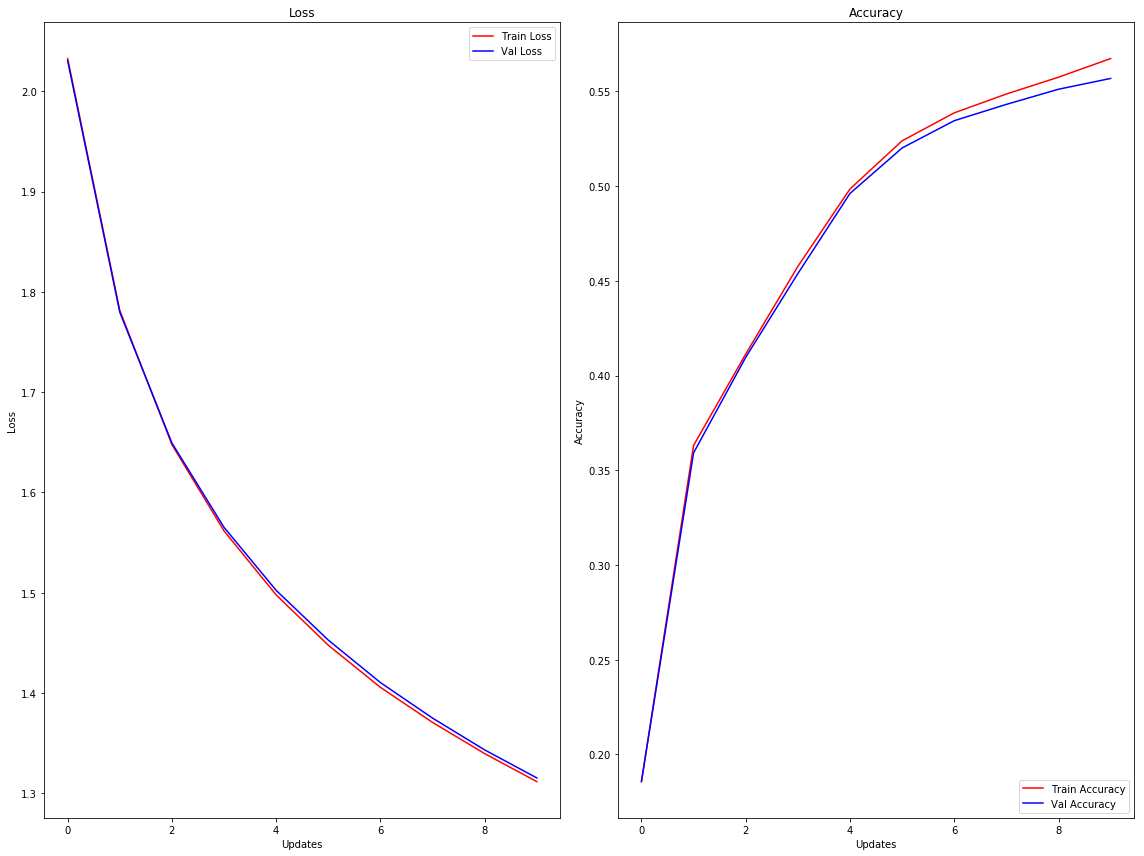

In [26]:
## Build the network
tf.reset_default_graph()
import datetime
num_features = mnist_data.train.images[0].shape[0]
num_classes = mnist_data.train.labels[0].shape[0]
num_features = num_features
num_output = num_classes

## Define placeholders
x_pl = tf.placeholder(tf.float32, [None, num_features], name='xPlaceholder')
y_pl = tf.placeholder(tf.float64, [None, num_classes], name='yPlaceholder')
# Depending on your implementation you might need to cast y_pl differently
y_pl = tf.cast(y_pl, tf.float32)

## Define the model


## Define placeholders
x_pl = tf.placeholder(tf.float32, [None, num_features], name='xPlaceholder')
# y_ is a placeholder variable taking on the value of the target batch.
# This is used for computing the loss.
y_pl = tf.placeholder(tf.float64, [None, num_classes], name='yPlaceholder')
# Depending on your implementation you might need to cast y_pl differently
y_pl = tf.cast(y_pl, tf.float32)

## Define hyperparameters !
num_epochs = 10
num_hidden1 = 2
num_hidden2 = 5
batch_size = 32

optimizer_choice = "RMSProp"   # Adam SGD RMSProp
learning_rate = 0.0001  # 1e-4 - 1e-5 for Adam, 0 - 1 for SGD

# Define where we want to save the TensorBoard summaries
timestr = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")
logdir = os.path.join('.', 'logdir', timestr)

########################################################################### 
################ DEFINE INITILIZATION OF WEIGHTS  ########################  
##########################################################################
## Define initializer for the weigths
# How the weights are initialized is very important for how well the network 
# trains. We will look into this later, but for now we will just use a normal 
# distribution.
weight_initializer = tf.truncated_normal_initializer(stddev=0.1)

########################################################################### 
################ CREATE PHISICAL MODEL ################################  
##############################################################################
### Create layer 1
with tf.variable_scope('layer1'): 
    W_1 = tf.get_variable('W1', [num_features, num_hidden1], 
                          initializer=weight_initializer)
    b_1 = tf.get_variable('b1', [num_hidden1],
                          initializer=tf.constant_initializer(0.0))
    
    with tf.variable_scope('OutputLayer1'):
        l_1 = tf.matmul(x_pl, W_1) + b_1  # Multiplication
        l_1 = tf.nn.relu(l_1)             # Nonlinear funciton
       # l_1 = tf.nn.tanh(l_1)             # Nonlinear funciton
### Create layer 2
with tf.variable_scope('layer2'): 
    W_2 = tf.get_variable('W2', [num_hidden1, num_output],
                          initializer=weight_initializer)
    b_2 = tf.get_variable('b2', [num_output], 
                          initializer=tf.constant_initializer(0.0))
    with tf.variable_scope('OutputLayer2'):
        l_2 = tf.matmul(l_1, W_2) + b_2  # Multiplication
        # The layer before the softmax should NOT have a nonlinearity
print('Model consits of ', utils.num_params(), 'trainable parameters.')
## Total output is the softmax of layer 2 !!
y = tf.nn.softmax(l_2) #

### Implement training ops


################ LOSS FUNCTION ################################  
with tf.variable_scope('loss'):
    # computing cross entropy per sample
    cross_entropy = -tf.reduce_sum(y_pl * tf.log(y), reduction_indices=[1])

    # Average over samples
    # Averaging makes the loss invariant to batch size, which is very nice.
    cross_entropy = tf.reduce_mean(cross_entropy)
    

################ PERFORMANCE FUNCTION (accuracy) ################################  
# Function applied to the output at each operation, we do not use cross_entropy anymore for this.
# Just the hard classificaiton error.
with tf.variable_scope('performance'):
    # making a one-hot encoded vector of correct (1) and incorrect (0) predictions
    correct_prediction = tf.equal(tf.argmax(y, axis=1), tf.argmax(y_pl, axis=1))

    # averaging the one-hot encoded vector
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.variable_scope('hard_decision'):
    hard_dec = tf.argmax(y_pl, axis=1)

summary_loss = tf.summary.scalar("performance/loss", cross_entropy)


########################################################################### 
################ DEFINE TRAINING !! ########################  
##########################################################################
    
################ OPTIMIZER ################################  
if (optimizer_choice == "SGD"):
    with tf.variable_scope('trainOP_GradientDescent'):
        # Defining our optimizer
        optimizer_GD = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
        # Computing our gradients
        grads_and_vars_GD = optimizer_GD.compute_gradients(cross_entropy)
        # Applying the gradients
        train_op_GD = optimizer_GD.apply_gradients(grads_and_vars_GD)
        
        ## The three steps above can be compressed into one: 
        # train_op = optimizer_GD.minimize(crossentropy)
elif(optimizer_choice == "Adam"):
    with tf.variable_scope('trainOP_ADAM'):
        # Defining our optimizer
        optimizer_Adam = tf.train.AdamOptimizer(   learning_rate=learning_rate,
                                           beta1=0.9,beta2=0.999,epsilon=1e-08,name='Adam' )
        # Computing our gradients
        grads_and_vars_Adam = optimizer_Adam.compute_gradients(loss = cross_entropy,
            var_list=None, aggregation_method=None, colocate_gradients_with_ops=False, grad_loss=None)
    
        # Applying the gradients
        train_op_Adam = optimizer_Adam.apply_gradients(grads_and_vars_Adam)
elif(optimizer_choice == "RMSProp"):
    with tf.variable_scope('trainOP_RMSProp'):
        # Defining our optimizer
        optimizer_RMSProp = tf.train.RMSPropOptimizer(   learning_rate=learning_rate,
        decay=0.9, momentum=0.0, epsilon=1e-10,use_locking=False,  centered=False, name='RMSProp')
        # Computing our gradients
        grads_and_vars_RMSProp = optimizer_RMSProp.compute_gradients(loss = cross_entropy,
            var_list=None, aggregation_method=None, colocate_gradients_with_ops=False, grad_loss=None)
    
        # Applying the gradients
        train_op_RMSProp = optimizer_RMSProp.apply_gradients(grads_and_vars_RMSProp)
    
if (optimizer_choice == "SGD"):
    train_op = train_op_GD
elif(optimizer_choice == "Adam"):
    train_op = train_op_Adam
elif(optimizer_choice == "RMSProp"):
    train_op = train_op_RMSProp

########################################################################### 
################ PREDICTOR OF THE SYSTEM ################################  
def pred(X_in, sess):
    # first we must define what data to give it
    feed_dict = {x_pl: X_in}
    # secondly our fetches
    fetches = [y]
    # utilizing the given session (ref. sess) to compute results
    res = sess.run(fetches, feed_dict)
    # res is a list with each indices representing the corresponding element in fetches
    return res[0]

def hard_decision(Y_in, sess):
    # first we must define what data to give it
    feed_dict = {y_pl: Y_in}
    # secondly our fetches
    fetches = [hard_dec]
    # utilizing the given session (ref. sess) to compute results
    res = sess.run(fetches, feed_dict)
    # res is a list with each indices representing the corresponding element in fetches
    return res[0]

## SETTING CONFIGURATION OF TENSORFLOW

num_epochs = 10
# restricting memory usage, TensorFlow is greedy and will use all memory otherwise
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.2)
# Initilize variables to use
train_cost, val_cost, train_acc, val_acc = [],[],[],[]

X_val = mnist_data.test.images
y_val = mnist_data.test.labels
X_tr = mnist_data.train.images
y_tr = mnist_data.train.labels
# Start the session to start our system !

aux_epochs_completed = 0
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:
    try:
        print('Begin training')
        # initializing all variables 
        init = tf.global_variables_initializer()
        sess.run(init)

        tmp_def = utils.rename_nodes(sess.graph_def, lambda s:"/".join(s.split('_',1)))

        # We use two summary writers. This is a hack that allows us to write 
        # show two plots in the same fiigure in TensorBoard
        summary_writer_train = tf.summary.FileWriter(os.path.join(logdir, 'train'), sess.graph)
        summary_writer_valid = tf.summary.FileWriter(os.path.join(logdir, 'valid'), sess.graph)


        for epoch in range(num_epochs):
            avg_cost = 0.
            total_batch = int(mnist_data.train.num_examples/batch_size)

            # Loop over all batches
            for i in range(total_batch):
                # Load one mini-batch
                x_b, y_b = mnist_data.train.next_batch(batch_size)
                ### TRAINING All the minibatches of the epoch###
                feed_dict_train = {x_pl: x_b, y_pl: y_b}
                # deciding which parts to fetch, train_op makes the classifier "train"
                fetches_train = [train_op]
                 # running the train_op
                res = sess.run(fetches=fetches_train, feed_dict=feed_dict_train)

            ############ Once the Epoch is finished ########

            # Now we do the forward for both train and test with all the data to compute statiscs.
            feed_dict_train = {x_pl: X_tr, y_pl: y_tr}
            fetches_train = [ cross_entropy, accuracy, summary_loss]
            res = sess.run(fetches=fetches_train, feed_dict=feed_dict_train)

            # storing cross entropy (second fetch argument, so index=1)
            train_cost += [res[0]]
            train_acc += [res[1]]
            summary_train = res[2]
            ### VALIDATING ###
            feed_dict_valid = {x_pl: X_val, y_pl: y_val}
            fetches_valid = [cross_entropy, accuracy, summary_loss]
            res = sess.run(fetches=fetches_valid, feed_dict=feed_dict_valid)

            val_cost += [res[0]]
            val_acc += [res[1]]
            summary_valid = res[2]
            ##### Write the summaries ############

            summary_writer_train.add_summary(summary_train, epoch)
            summary_writer_valid.add_summary(summary_valid, epoch)

            if epoch % 2 == 0:
                print("Epoch %i, Train Cost: %0.3f\tVal Cost: %0.3f\t Val acc: %0.3f" \
                      %(epoch, train_cost[-1],val_cost[-1],val_acc[-1]))

        ################### GET SOME OF THE FINAL PREDICTED IMAGES ###################
        validation_predicted = pred(X_val,sess)  # Predicted validation of all samples

         # Predicted validation of a sample
        indx = 12
        validation_predicted_indx = pred(X_val[[indx],:],sess)
        y_val_hard = hard_decision(y_val, sess)
        y_pred_hard =  hard_decision(validation_predicted, sess)

        ### CREATE THE CONFUSION MATRIX !!
        class_names = [str(x) for x in range(10)]
        confusionMatrix = utils.ConfusionMatrix(10,class_names)
        confusionMatrix.batch_add(y_val_hard,y_pred_hard)

    except KeyboardInterrupt:
        print('KeyboardInterrupt')
print('Done')


epoch = np.arange(len(train_cost))

fig = plt.figure(figsize=(16,12))
fig.add_subplot(121)
plt.title('Loss')
plt.plot(epoch, train_cost,'r', label='Train Loss')
plt.plot(epoch, val_cost,'b', label='Val Loss')
plt.legend()
plt.xlabel('Updates'), plt.ylabel('Loss')

fig.add_subplot(122)
plt.title('Accuracy')
plt.plot(epoch, train_acc,'r', label='Train Accuracy')
plt.plot(epoch, val_acc,'b', label='Val Accuracy')
plt.legend(loc=4)
plt.xlabel('Updates'), plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

## 

# Exercise from the book
#### <span style="color:red"> Sigmoid neurons simulating perceptrons, part I.
</span>
Suppose we take all the weights and biases in a network of perceptrons, and multiply them by a positive constant, c>0. Show that the behaviour of the network doesn't change.

<b>Solution</b>:

Given that the activation funciton of the perceptron is pretty much a saturation function. Which will be 1 if z is positive and 0 otherwise. If we multiply all the weights and parameters by the same constant c, then the output of the neuron before the activation function will be $c*z$. Since this operation does not change the sign of $z$, or makes the result 0 (given the contraint x > 0), then the output after the activation funciton is the same. 
